## Use FNN for multi-class classification problem
In this notebook, we show how to use FNN to classify a multi-class dataset using soft max for output layer and cross entropy for cost function.


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sys
import os
import logging
logging.basicConfig(level=logging.DEBUG) # Enable this if you want extra debug info

np.random.seed(1)
sys.path.append(os.path.abspath('..'))

### Prepare Dataset
The code of the dataset was taken from course [CS231n Convolutional Neural Networks for Computer Vision by Andrej Karpathy Ng](https://cs231n.github.io/). It consist of C classes of points on a 2D planar following a helical distribution. Each sample is labeled with `Y=n` where `n` is the class of the point

Dataset, Train: 570, Test: 30


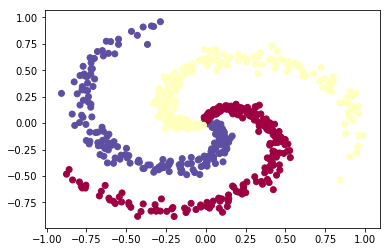

In [2]:
from examples.planar import load_spyral_dataset, plot_decision_boundary
from mynn.preprocess import StandardScaler

N=200
C=3
test_percent = 0.05
toys_X, toys_Y = load_spyral_dataset(N=N)
toys_X = toys_X.T
toys_Y = toys_Y.reshape(-1, 1).T
m = toys_X.shape[1]

# Shuffle examples
shuffle_args = np.random.permutation(toys_X.shape[1])
toys_X = toys_X[:,shuffle_args]
toys_Y = toys_Y[:,shuffle_args]

# Split test, train
split_point = int(m - m * test_percent)

train_X = toys_X[:,:split_point]
train_Y = toys_Y[:,:split_point]
test_X = toys_X[:,split_point:]
test_Y = toys_Y[:,split_point:]

# Center the dataset and normalize variance
scaler = StandardScaler()
scaler.train(train_X)
train_X = scaler.scale(train_X)
test_X = scaler.scale(test_X)

print(f"Dataset, Train: {train_X.shape[1]}, Test: {test_X.shape[1]}")
plt.scatter(toys_X[0, :], toys_X[1, :], c=toys_Y.squeeze(), cmap=plt.cm.Spectral)
plt.show()


### Train a 4-Layers FNN
We will use 4 hidden layer with `relu` activation function and one `softmax` output layer.


In [6]:
from mynn import NNModel
from mynn.activation import ReLUActivation, SigmoidActivation
from mynn.optimizers import Adam, GradientDescent, RMSProp, GradientDescentMomentum
from mynn.regularization import DropoutRegularization, L2Regularization
from mynn.validation import performance_training_callback
from mynn.endecoders import OneHotEncoderDecoder
from mynn.loss import SoftmaxCrossEntropyLoss
from mynn.layers import FullyConnected as FC, Input
from mynn.validation import performance_training_callback

x_input = Input((train_X.shape[0], None))
x = FC(10, ReLUActivation)(x_input)
x = FC(7, ReLUActivation)(x)
x = FC(5, ReLUActivation)(x)
x = FC(3)(x)

nn_parameters = {
    'inputs': x_input,
    'outputs': x,
#     'regularization': DropoutRegularization(keep_probs=[0.5, 0.8, 0.8, 1]),
    'optimizer': Adam(learning_rate=0.002),
    'loss_function': SoftmaxCrossEntropyLoss(),
    'output_encoder_decoder': OneHotEncoderDecoder(classes=list(range(0, C)))
}

epochs=500
nn = NNModel(**nn_parameters)

costs_cb = performance_training_callback(
    [train_X, test_X],
    [train_Y, test_Y],
    every_nth_iteration=25,
    prediction_kwargs={'average':'micro'})
ctx = nn.train(train_X, train_Y, epochs=epochs, post_iteration_callbacks=[costs_cb], mini_batch_size=128)



DEBUG:mynn.network:Initialized NN network model
DEBUG:mynn.network:  Layers: max-depth=4 total=#5
DEBUG:mynn.network:  Optimizer: Adam(learning_rate=0.002,beta=0.9,beta2=0.99,bias_correction=True)
DEBUG:mynn.network:  Weight Initializer: XavierWeightInitializer(2)
DEBUG:mynn.network:  Regularization: None
DEBUG:mynn.network:  Encoder/Decoder: OneHotEncoderDecoder(classes=[0 1 2])
DEBUG:mynn.network:Training on X: (2, 570), Y: (1, 570) for 500 epochs.
DEBUG:mynn.network:Enabling mini-batch optimization with size=128
DEBUG:mynn.network:Encoding Y variable
DEBUG:mynn.network:[0:00:00.011220|ep:0|mb:0] Current cost 1.171977542499378.
DEBUG:mynn.network:[0:00:00.018001|ep:0|mb:4] Current cost 1.1492717472635239. Finishing in None.
DEBUG:mynn.network:[0:00:00.028308|ep:1|mb:4] Current cost 1.0617942652639245. Finishing in 0:00:06.812847.
DEBUG:mynn.network:[0:00:00.033592|ep:2|mb:4] Current cost 0.9682258090958903. Finishing in 0:00:05.964913.
DEBUG:mynn.network:[0:00:00.041535|ep:3|mb:4] Cu

DEBUG:mynn.network:[0:00:00.657562|ep:61|mb:4] Current cost 0.3117112966688633. Finishing in 0:00:05.502860.
DEBUG:mynn.network:[0:00:00.666057|ep:62|mb:4] Current cost 0.41415214158991687. Finishing in 0:00:05.650166.
DEBUG:mynn.network:[0:00:00.673984|ep:63|mb:4] Current cost 0.3784462120030706. Finishing in 0:00:05.447406.
DEBUG:mynn.network:[0:00:00.683019|ep:64|mb:4] Current cost 0.39451820846012314. Finishing in 0:00:05.235433.
DEBUG:mynn.network:[0:00:00.691721|ep:65|mb:0] Current cost 0.318185501157126.
DEBUG:mynn.network:[0:00:00.705693|ep:65|mb:4] Current cost 0.28187961406002676. Finishing in 0:00:05.091573.
DEBUG:mynn.network:[0:00:00.714959|ep:66|mb:4] Current cost 0.3528849555400517. Finishing in 0:00:05.566423.
DEBUG:mynn.network:[0:00:00.723112|ep:67|mb:4] Current cost 0.33452807075123425. Finishing in 0:00:05.390048.
DEBUG:mynn.network:[0:00:00.731140|ep:68|mb:4] Current cost 0.2863858937460996. Finishing in 0:00:05.202888.
DEBUG:mynn.network:[0:00:00.739470|ep:69|mb:4

DEBUG:mynn.network:[0:00:01.405420|ep:126|mb:4] Current cost 0.06787036497623931. Finishing in 0:00:04.426799.
DEBUG:mynn.network:[0:00:01.412228|ep:127|mb:4] Current cost 0.1145842031425723. Finishing in 0:00:04.352844.
DEBUG:mynn.network:[0:00:01.422733|ep:128|mb:4] Current cost 0.08308081710545821. Finishing in 0:00:04.172293.
DEBUG:mynn.network:[0:00:01.435477|ep:129|mb:4] Current cost 0.05405782341407379. Finishing in 0:00:04.134853.
DEBUG:mynn.network:[0:00:01.443105|ep:130|mb:0] Current cost 0.05773306284839255.
DEBUG:mynn.network:[0:00:01.453034|ep:130|mb:4] Current cost 0.10981464615980958. Finishing in 0:00:04.171210.
DEBUG:mynn.network:[0:00:01.460550|ep:131|mb:4] Current cost 0.03741501685236837. Finishing in 0:00:04.387258.
DEBUG:mynn.network:[0:00:01.470921|ep:132|mb:4] Current cost 0.06014816052196114. Finishing in 0:00:04.219351.
DEBUG:mynn.network:[0:00:01.478203|ep:133|mb:4] Current cost 0.07262296743127719. Finishing in 0:00:04.159675.
DEBUG:mynn.network:[0:00:01.487

DEBUG:mynn.network:[0:00:02.041002|ep:191|mb:4] Current cost 0.030815274804601157. Finishing in 0:00:03.086140.
DEBUG:mynn.network:[0:00:02.047463|ep:192|mb:4] Current cost 0.025662305290287908. Finishing in 0:00:03.021590.
DEBUG:mynn.network:[0:00:02.055659|ep:193|mb:4] Current cost 0.01981583141279827. Finishing in 0:00:02.921726.
DEBUG:mynn.network:[0:00:02.061889|ep:194|mb:4] Current cost 0.06326698254339654. Finishing in 0:00:02.868572.
DEBUG:mynn.network:[0:00:02.070145|ep:195|mb:0] Current cost 0.004258076387711986.
DEBUG:mynn.network:[0:00:02.078201|ep:195|mb:4] Current cost 0.010761799322050255. Finishing in 0:00:02.816607.
DEBUG:mynn.network:[0:00:02.085950|ep:196|mb:4] Current cost 0.03599043295813106. Finishing in 0:00:02.980142.
DEBUG:mynn.network:[0:00:02.093875|ep:197|mb:4] Current cost 0.04323893379772463. Finishing in 0:00:02.894677.
DEBUG:mynn.network:[0:00:02.101540|ep:198|mb:4] Current cost 0.0241439198032325. Finishing in 0:00:02.829514.
DEBUG:mynn.network:[0:00:02

DEBUG:mynn.network:[0:00:02.646991|ep:255|mb:4] Current cost 0.02294767159506184. Finishing in 0:00:02.372230.
DEBUG:mynn.network:[0:00:02.653396|ep:256|mb:4] Current cost 0.0012430469672690338. Finishing in 0:00:02.549267.
DEBUG:mynn.network:[0:00:02.663098|ep:257|mb:4] Current cost 0.020108793349881252. Finishing in 0:00:02.502325.
DEBUG:mynn.network:[0:00:02.673898|ep:258|mb:4] Current cost 0.010557492275212693. Finishing in 0:00:02.413193.
DEBUG:mynn.network:[0:00:02.682748|ep:259|mb:4] Current cost 0.0007927156141834956. Finishing in 0:00:02.410791.
DEBUG:mynn.network:[0:00:02.691352|ep:260|mb:0] Current cost 0.012518734766180139.
DEBUG:mynn.network:[0:00:02.697923|ep:260|mb:4] Current cost 0.013190179611450028. Finishing in 0:00:02.371069.
DEBUG:mynn.network:[0:00:02.707675|ep:261|mb:4] Current cost 0.005096926329376417. Finishing in 0:00:02.493920.
DEBUG:mynn.network:[0:00:02.716921|ep:262|mb:4] Current cost 0.012051941157617384. Finishing in 0:00:02.462545.
DEBUG:mynn.network:[

DEBUG:mynn.network:[0:00:03.277533|ep:320|mb:0] Current cost 0.015539312389929134.
DEBUG:mynn.network:[0:00:03.284399|ep:320|mb:4] Current cost 0.0007040414682026953. Finishing in 0:00:01.625030.
DEBUG:mynn.network:[0:00:03.292984|ep:321|mb:4] Current cost 0.00038820907741886557. Finishing in 0:00:01.731458.
DEBUG:mynn.network:[0:00:03.301808|ep:322|mb:4] Current cost 0.010878036167064689. Finishing in 0:00:01.701885.
DEBUG:mynn.network:[0:00:03.312122|ep:323|mb:4] Current cost 0.023289218806339763. Finishing in 0:00:01.680268.
DEBUG:mynn.network:[0:00:03.319627|ep:324|mb:4] Current cost 0.00138611448378607. Finishing in 0:00:01.686438.
DEBUG:mynn.network:[0:00:03.328781|ep:325|mb:0] Current cost 0.013909022303977685.
DEBUG:mynn.network:[0:00:03.336139|ep:325|mb:4] Current cost 0.008218415114696247. Finishing in 0:00:01.657990.
DEBUG:mynn.network:[0:00:03.344375|ep:326|mb:4] Current cost 0.0018747811551033827. Finishing in 0:00:01.753138.
DEBUG:mynn.network:[0:00:03.351345|ep:327|mb:4]

DEBUG:mynn.network:[0:00:03.857778|ep:384|mb:4] Current cost 0.036151189584703376. Finishing in 0:00:01.004277.
DEBUG:mynn.network:[0:00:03.864312|ep:385|mb:0] Current cost 0.009961214611794672.
DEBUG:mynn.network:[0:00:03.869761|ep:385|mb:4] Current cost 0.0004474220557322895. Finishing in 0:00:00.977201.
DEBUG:mynn.network:[0:00:03.878088|ep:386|mb:4] Current cost 0.0003409709914171556. Finishing in 0:00:01.030168.
DEBUG:mynn.network:[0:00:03.886026|ep:387|mb:4] Current cost 0.0018345028930195923. Finishing in 0:00:00.991440.
DEBUG:mynn.network:[0:00:03.894571|ep:388|mb:4] Current cost 0.011863464804451234. Finishing in 0:00:00.971726.
DEBUG:mynn.network:[0:00:03.901315|ep:389|mb:4] Current cost 0.002984443390169388. Finishing in 0:00:00.963726.
DEBUG:mynn.network:[0:00:03.909911|ep:390|mb:0] Current cost 0.024302487116013786.
DEBUG:mynn.network:[0:00:03.917770|ep:390|mb:4] Current cost 0.005379188784794759. Finishing in 0:00:00.931468.
DEBUG:mynn.network:[0:00:03.925746|ep:391|mb:4]

DEBUG:mynn.network:[0:00:04.478793|ep:448|mb:4] Current cost 0.0003617347981549017. Finishing in 0:00:00.500820.
DEBUG:mynn.network:[0:00:04.486219|ep:449|mb:4] Current cost 8.86249108282498e-05. Finishing in 0:00:00.485599.
DEBUG:mynn.network:[0:00:04.494851|ep:450|mb:0] Current cost 0.008918352460361973.
DEBUG:mynn.network:[0:00:04.504339|ep:450|mb:4] Current cost 0.0019153101289364441. Finishing in 0:00:00.461914.
DEBUG:mynn.network:[0:00:04.513875|ep:451|mb:4] Current cost 0.013124437336957142. Finishing in 0:00:00.506134.
DEBUG:mynn.network:[0:00:04.520407|ep:452|mb:4] Current cost 0.009369559828834698. Finishing in 0:00:00.484437.
DEBUG:mynn.network:[0:00:04.529259|ep:453|mb:4] Current cost 0.001316158739685714. Finishing in 0:00:00.456863.
DEBUG:mynn.network:[0:00:04.536518|ep:454|mb:4] Current cost 0.012142737796888885. Finishing in 0:00:00.442609.
DEBUG:mynn.network:[0:00:04.545341|ep:455|mb:0] Current cost 0.017246899687886664.
DEBUG:mynn.network:[0:00:04.552519|ep:455|mb:4] 

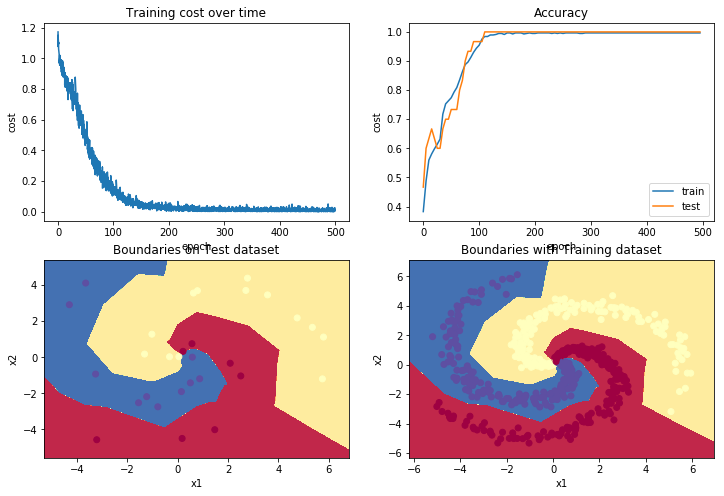

In [17]:
df = ctx.iterations_history_as_dataframe()
df_dense = df.dropna()
f, axarr = plt.subplots(2, 2, squeeze=False, figsize=(12, 8))
axarr[0][0].plot(df['epoch'], df['loss'])
axarr[0][0].set_xlabel('epoch')
axarr[0][0].set_ylabel('cost')
axarr[0][0].set_title('Training cost over time')

axarr[0][1].plot(df_dense['epoch'], df_dense['accuracy_0'])
axarr[0][1].plot(df_dense['epoch'], df_dense['accuracy_1'])
axarr[0][1].legend(['train', 'test'])
axarr[0][1].set_xlabel('epoch')
axarr[0][1].set_ylabel('cost')
axarr[0][1].set_title('Accuracy')


plot_decision_boundary(lambda x: nn.predict(x.T).reshape(-1,1), train_X, train_Y.reshape(-1), ax=axarr[1][1])
axarr[1][1].set_title('Boundaries with Training dataset')
plot_decision_boundary(lambda x: nn.predict(x.T).reshape(-1,1), test_X, test_Y.reshape(-1), ax=axarr[1][0])
axarr[1][0].set_title('Boundaries on Test dataset')
plt.show()

### Conclusions
From the cost over time plot we can see the the network had a smooth training. From the accuracy graph the model has a low bias and variance. With a final accuracy of ~100% on both training and test dataset.

The second row provides a visualization of the trained model by sampling the decision boundaries.